# Исследование успешности продаж онлайн-игр

## Цель проекта

Необходимо проанализировать, влияют ли оценки критиков и/ли пользователей на успешность той или иной онлайн-игры на основе данных о продажах из публичных источников. Такое исследование позволит:
* выработать методологию для формирования каталога магазина "Стримчик", основанную на количественных критериях, что будет способствоать улучшению предлагаемого ассортимента;
* оптимизировать распределение рекламных бюджетов в зависимости от ожидаемой успешности продукта.

Для выполнения поставленной цели нужно предпринять следующие шаги:

1) изучить состав и структуру исходных данных;

2) выявить и устранить возможные проблемы в данных, а именно пропуски, дубликаты, выбросы. Это необходимо для улучшения качества последующего анализа;

3) определить, насколько исходные данные соответствуют текущим реалиям для посторения прогнозов. Если не все данные релевантны, определить актуальные данные, позволяющие сделать прогноз на 2017 г.;

4) проанализировать зависимость продаж от отзывов пользователей и критиков, установить наличие и характер взаимосвязей;

5) поставить портрет пользователя для каждого региона (предпочитаемые платформы, жанры и т.п.).

## Обзор данных

Информация к анализу представляет собой данные о кумулятивныхх продажах онлайн-игр на различных платформах вплоть до 2016 г., доступные из публичных источников.

Рассмотрим состав и структуру имеющихся данных.

### Состав и структура данных

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt

In [2]:
# Загрузим датасет и получим первое представление о данных:
df = pd.read_csv('datasets/games.csv')
display(df.head())

df.info()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Датасет содержит информацию о:
* названии  и жанре игры, 
* платформе продаж, 
* годе выхода игры на той или иной платформе,
* количестве проданных копий (в миллионах) в различных регионах (Северная Америка, Европа, Япония и прочие регионы),
* рейтинге критиков (100-балльнавя шкала) и пользователей (10-балльная шкала), 
* возрастном рейтинге, присвоенном ESRB. 

Заметим, что данные о платформе-распространителе и количестве продаж полные (нет пропусков), в то время как в других столбцах есть пропущенные значения, что нужно будет учесть при подготовке информации к анализу.

Кроме того, типы некоторых параметров не соответствуют ожидаемым:
* Данные о годе релиза определились как *float*, хотя для них применим целочисленный тип *int*;
* Данные о рейтиге среди критиков, возможно, также можно перевести в целочисленный тип, т.к. предполагается 100-балльная шкала;
* Данные о рейтинге среди пользователей определились как *object*, хотя для них характерен тип *float*.

При подготовке данных к анализу следует выяснить, по каким причинам тип данных не соответсвует ожидаемому, и привести данные к нужному типу.

Для упрощения работы над данными избавимся от заглавных букв в названии столбцов. После этого рассмотрим структуру имеющихся показателей.

Количество уникальных игр: 11559
Количество уникальных жанров: 12
Количество уникальных платформ: 31


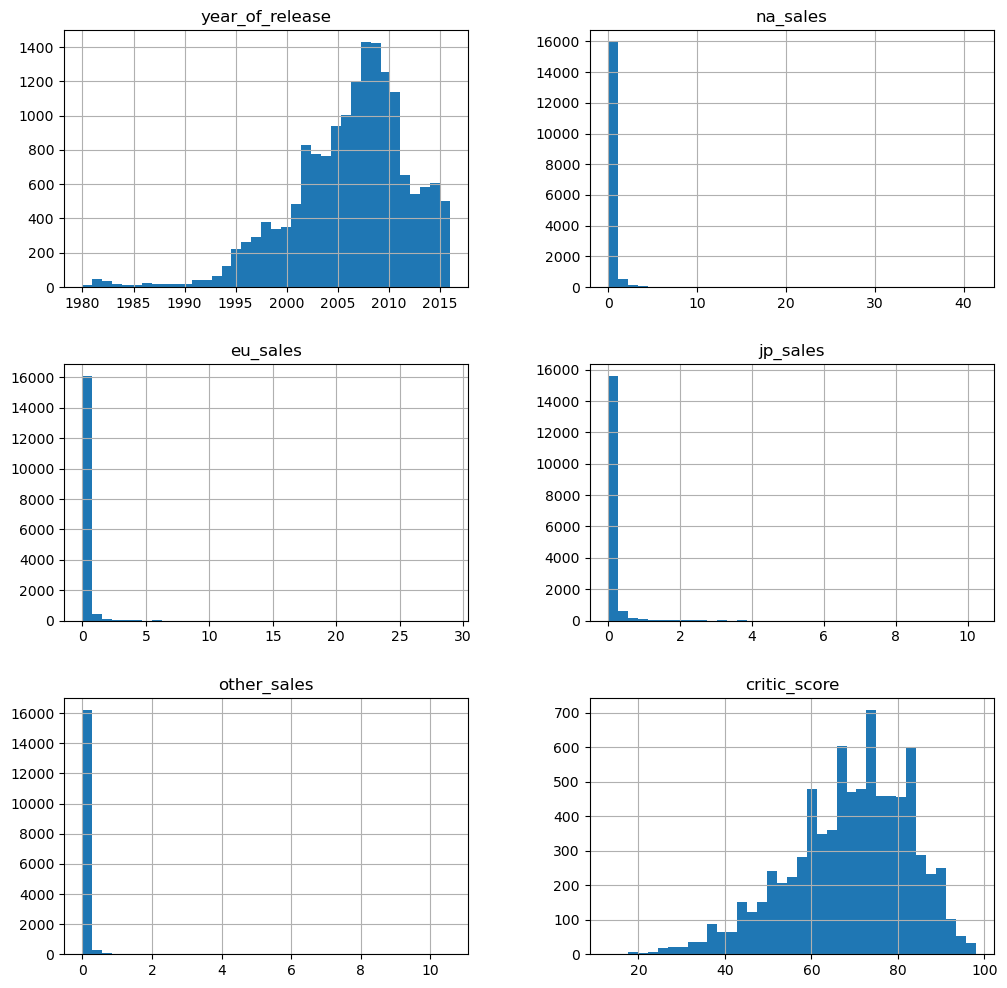

In [3]:
df.columns = df.columns.str.lower() # приведем названия столбцов к нижнему регистру;

# Структура имеющихся данных:
print('Количество уникальных игр:', df['name'].nunique())
print('Количество уникальных жанров:', df['genre'].nunique())
print('Количество уникальных платформ:', df['platform'].nunique())

df.hist(bins=37, figsize=(12, 12)); # количество корзин подобранно по количеству лет релиза в выборке

initial_size = len(df) # для контроля размера выборки

* **Уникальных наименований** игр в выборке ок. 11,5 тыс. из 16 тыс. наблюдений, т.е. одна и та же игра может встречаться в выборке несколько раз (напр., на разных платформах).
* Все игры разбиты по 12 **жанрам**.
* Активный рост **количества выпускаемых игр** начинается с середины 1990-х годов, пик по количеству выпущенных игр приходится на 2007-2010 гг. Затем количество выпущенных игр сокращается (возможное объяснение: стало выходить меньше игр, однако проекты стали более масштабными).
* В данных есть информация о продажах с 31 уникальной **платформы**.
* В данных о **количестве продаж**, судя по выдающимся горизонтальным осям, присутсвуют необычайно большие значения по сравнению с типичными наблюдениями. Необходимо удостовериться, что это не ошибка в данных (напр., продажи в тыс., а не в млн копий).
* Большинство проектов получили **оценку от критиков** в диапазоне 60-80 (по данным, где рейтинг указан). В распределении присутствуют пики (необходимо понять их природу).
* Информация о рейтинге **среди пользователей** содержит данные разных типов, что не позволило построить гистограмму для показателя.

### Вывод

Исходные данные содержат ок. 16,2 тыс. наблюдений о продажах примерно 11,5 тыс. игр через 31 платформу. Даты выхода игр охватывают период с 1980 г. по 2016 г. Имеется информация как о характеристиках игр (жанр, рейтинги), так и детализация продаж (платформа, количество проданных копий в разных регионах).

Данные о продажах полные, в то время как в информации о характеристиках игры имеются пропуски (в основном в присвоенных игре рейтингах). Кроме того, в данных о количестве проданных копий есть необычно большие значения, нужно удостовериться, что в них нет ошибки. 

Таким образом, для дальнейшего анализа и улучшения надежности выводов необходима предобработка данных.

## Предобработка данных
### Заполнение пропусков
Рассмотрим, какую долю от количества наблюдений (в процентах) составляют пропуски в тех или иных данных:

In [4]:
pd.DataFrame(round(df.isna().mean()*100, 3)).style.background_gradient()

,0
name,0.012000
platform,0.000000
year_of_release,1.609000
genre,0.012000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
critic_score,51.319000
user_score,40.090000


#### Наименование и жанр
Количество пропусков в названии и жанре незначительно - всего 2 строки из более 16 тыс. Удалим эти данные из выборки:

In [5]:
df = df[~(df['name'].isna()) & ~(df['genre'].isna())]

#### Дата выхода

Пропуски в дате выхода игры составляют ок. 2% выборки. Заполним часть пропусков датой выхода игры на другой платформе (предполагаем, что релиз происходит на всех платформах в один год или в близкий период +- 1 год).

In [6]:
import warnings
warnings.filterwarnings('ignore')

# Найдем количество пропусков до заполнения:
print('Количество пропусков до заполнения:', df['year_of_release'].isna().sum())

# Найдем значения по другим платформам:
pivot = df.pivot_table(index = 'name', values = 'year_of_release', aggfunc = 'median') # если года все же разные - медиана,
pivot['year_of_release'] = round(pivot['year_of_release']) # если медиана дробная - округлим ее

# Заполним пропуски, где возможно, медианным значением по другим платформам:
for name in df[df['year_of_release'].isna()]['name'].unique():                     
    if name in pivot.index:
        df.loc[(df['name'] == name) & (df['year_of_release'].isna()), 'year_of_release'] = pivot.loc[name, 'year_of_release']
    
# Найдем количество оставшихся пропусков:
print('Количество пропусков после заполнения:', df['year_of_release'].isna().sum())

Количество пропусков до заполнения: 269
Количество пропусков после заполнения: 146


В результате заполнили ок. половины имеющихся пропусков. Оставшиеся пропуски предлагается удалить после заполнения пробелов в других показателях, т.к. доля их от общей выборки невелика.



#### Оценки критиков и пользователей
Пропуски в отзывах критиков составляют более 50% всей выборки, в оценках пользователей - более 40%. Предлагается заполнить пропуски там, где возможно, медианным значением по всем платформам. Однако прежде поймем, являются ли оценки критиков по 100-балльной шкале целыми числами, а также причины определения типа пользовательской оценки как *object*.

In [7]:
print('Возможные дробные части в оценке критиков:', (df['critic_score'] % 1).unique()) # выделяем дробную часть

print('Уникальные пользовательские оценки:') 
print(df['user_score'].unique())

Возможные дробные части в оценке критиков: [ 0. nan]
Уникальные пользовательские оценки:
['8' nan '8.3' '8.5' '6.6' '8.4' '8.6' '7.7' '6.3' '7.4' '8.2' '9' '7.9'
 '8.1' '8.7' '7.1' '3.4' '5.3' '4.8' '3.2' '8.9' '6.4' '7.8' '7.5' '2.6'
 '7.2' '9.2' '7' '7.3' '4.3' '7.6' '5.7' '5' '9.1' '6.5' 'tbd' '8.8' '6.9'
 '9.4' '6.8' '6.1' '6.7' '5.4' '4' '4.9' '4.5' '9.3' '6.2' '4.2' '6' '3.7'
 '4.1' '5.8' '5.6' '5.5' '4.4' '4.6' '5.9' '3.9' '3.1' '2.9' '5.2' '3.3'
 '4.7' '5.1' '3.5' '2.5' '1.9' '3' '2.7' '2.2' '2' '9.5' '2.1' '3.6' '2.8'
 '1.8' '3.8' '0' '1.6' '9.6' '2.4' '1.7' '1.1' '0.3' '1.5' '0.7' '1.2'
 '2.3' '0.5' '1.3' '0.2' '0.6' '1.4' '0.9' '1' '9.7']


* **Оценка критиков**: видим, что дробная часть в оценке критиков - либо 0, либо ее нет, т.е. показатель по сути имеет целочисленный тип. Значит, и медианная оценка должна быть целочисленной. 
* **Оценка пользователей**: заметим, что среди значений присутствует строковое значение "tbd". Выведем строки, для которых оценка пользователей обозначена таким образом:

In [8]:
print('Количество строк с рейтингом "tbd":', len(df.query('user_score == "tbd"')))
display(df.query('user_score == "tbd"').head(10))

Количество строк с рейтингом "tbd": 2424


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010.0,Sports,3.45,2.59,0.00,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2.08,1.35,0.00,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011.0,Sports,1.51,1.03,0.00,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.00,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.00,0.07,73.0,tbd,E
718,Just Dance Kids,Wii,2010.0,Misc,1.52,0.54,0.00,0.18,NaN,tbd,E
726,Dance Dance Revolution X2,PS2,2009.0,Simulation,1.09,0.85,0.00,0.28,NaN,tbd,E10+
821,The Incredibles,GBA,2004.0,Action,1.15,0.77,0.04,0.10,55.0,tbd,E
881,Who wants to be a millionaire,PC,1999.0,Misc,1.94,0.00,0.00,0.00,NaN,tbd,E
1047,Tetris Worlds,GBA,2001.0,Puzzle,1.25,0.39,0.00,0.06,65.0,tbd,E


Видим, что игры с "заглушкой" на месте пользовательского рейтинга выходили в разные периоды, на разных платформах и в разных жанрах, т.е. нет никакого критерия, по которому их можно было бы объединить. Также, судя по датам выхода, эти игры нельзя назвать только что вышедшими, по которым рейтинг еще не определен. Скорее, по каким-то причинам рейтинг еще не был присвоен этим играм на момент агрегации данных, а впоследствии данные не были обновлены. Таким образом, для целей анализа значение "tbd" равносильно пропуску. Заменим его на пропуск. Далее найдем, насколько сильно пересекаются подможества строк с пропусками в оценках пользователей и критиков:

In [9]:
import numpy as np
# Заменяем "tbd" в оценке пользователей на пропуск и приводим в числовой тип:
df['user_score'] = df['user_score'].replace('tbd', np.nan)
df['user_score'] = pd.to_numeric(df['user_score'])

print('Количество строк без оценок критиков:', df['critic_score'].isna().sum())
print('Количество строк без оценок пользователей:', df['user_score'].isna().sum())
print('Количество строк без оценок обоих видов:', (df['critic_score'].isna() & df['user_score'].isna()).sum())

Количество строк без оценок критиков: 8576
Количество строк без оценок пользователей: 9123
Количество строк без оценок обоих видов: 8003


Видим, что в большистве случаев это одни и те же строки. Возможно, наличие пропусков в рейтингах обусловлено тем, что какие-то платформы не собирают рейтинг или не публиковали рейтинг в отчетах о количестве проданных копий. Проверим предположение:

In [10]:
# Список платформ, где есть строки с пропусками в обеих оценках:
no_scores = df[(df['user_score'].isna()) & (df['critic_score'].isna())]['platform'].unique()
print('Платформы, где есть пропуски в обеих оценках:', len(no_scores))
print(no_scores)

# Список платформ, где встречаются строки с обеими оценками:
both_scores = df[~(df['user_score'].isna()) & ~(df['critic_score'].isna())]['platform'].unique()
print('Платформы, где указаны обе оценки:', len(both_scores))
print(both_scores)

# Список платформ, где нет ни одной строки с обеими оценками:
no_intersect = []
for t in no_scores:
    if t not in both_scores:
        no_intersect.append(t)
print('Платформы, где нет строк с обеими оценками:', len(no_intersect))
print(no_intersect)

Платформы, где есть пропуски в обеих оценках: 31
['NES' 'GB' 'DS' 'SNES' 'GBA' 'PS4' '3DS' 'N64' 'X360' 'Wii' '2600' 'PS'
 'XOne' 'GC' 'PS3' 'GEN' 'PC' 'PSP' 'WiiU' 'PS2' 'XB' 'DC' 'PSV' 'SAT'
 'SCD' 'WS' 'NG' 'TG16' '3DO' 'GG' 'PCFX']
Платформы, где указаны обе оценки: 17
['Wii' 'DS' 'X360' 'PS3' 'PS2' '3DS' 'PS4' 'PS' 'XB' 'PC' 'PSP' 'WiiU'
 'GC' 'GBA' 'XOne' 'PSV' 'DC']
Платформы, где нет строк с обеими оценками: 14
['NES', 'GB', 'SNES', 'N64', '2600', 'GEN', 'SAT', 'SCD', 'WS', 'NG', 'TG16', '3DO', 'GG', 'PCFX']


Нет ни одной платформы, где не было бы ни одной строки с пропусками в обеих оценках. Т.е. возможно, что оценки выставляются не всем играм (напр., после какого-то порога продаж). При этом для 14 из 31 платформы нет ни одной строки, где встречались бы сразу обе оценки. Проверим, есть ли на таких платформах хотя бы одна из двух оценок:

In [11]:
selection = df.query('platform in @no_intersect')
print('Общее число строк для выбранных платформ:', len(selection))

selection = selection[~(selection['user_score'].isna()) | ~(selection['critic_score'].isna())]
print('Количество строк выбранных платформ, где есть хотя бы одна оценка:', len(selection))

Общее число строк для выбранных платформ: 1118
Количество строк выбранных платформ, где есть хотя бы одна оценка: 0


На 14 из 31 платформу приходится всего чуть более 1 тыс. строк из 16 тыс., т.е. это небольшие платформы, которые не предоставляют информацию о рейтинге игры. Скорее всего, эти платформы будут в дальнейшем исключены из анализа как нерелевантные. Однако они объясняют причины пропусков лишь в 1 тыс. из 8-9 тыс. строк с пропусками.

Заполним пропущенные значения, где это возможно, медианными оценками игры на других платформах. Для оценки критиков медиана должна быть целочисленной.

In [12]:
# Найдем значения оценки критиков по другим платформам:
pivot = df.pivot_table(index = 'name', values = 'critic_score', aggfunc = 'median')
pivot['critic_score'] = round(pivot['critic_score']) # если медиана дробная - округлим ее

# Заполним пропуски, где возможно, медианным значением по другим платформам:
for name in df[df['critic_score'].isna()]['name'].unique():                     
    if name in pivot.index:
        df.loc[(df['name'] == name) & (df['critic_score'].isna()), 'critic_score'] = pivot.loc[name, 'critic_score']

# Найдем значения оценки пользователей по другим платформам:
pivot = df.pivot_table(index = 'name', values = 'user_score', aggfunc = 'median')

# Заполним пропуски, где возможно, медианным значением по другим платформам:
for name in df[df['user_score'].isna()]['name'].unique():                     
    if name in pivot.index:
        df.loc[(df['name'] == name) & (df['user_score'].isna()), 'user_score'] = pivot.loc[name, 'user_score']
    
# Найдем количество оставшихся пропусков:
print('Количество пропусков в оценке критиков после заполнения:', df['critic_score'].isna().sum())
print('Количество пропусков в оценке пользователей после заполнения:', df['user_score'].isna().sum())

Количество пропусков в оценке критиков после заполнения: 7615
Количество пропусков в оценке пользователей после заполнения: 8024


Указанным методом удалось устранить примерно по 1 тыс. пропусков в каждом из параметров. Остальные пропуски предлагается оставить без изменений, т.к. заполнение их медианой по жанру существенно исказит распределения, а их удаление приведет к потере большого блока данных.

#### Рейтинг ESRB

Рассмотрим перечень уникальных значений рейтинга:

In [13]:
print(df['rating'].unique())

['E' nan 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']


Как и в случае с оценкой пользователей, в списке уникальных значений, помимо пропусков, есть "заглушка" RP - rating pending, т.е. ожидается присвоение оценки. Обработаем это значение по аналогии с "tbd" в пользовательской оценке и заполним часть пропусков рейтингом с других платформ:

In [14]:
# Заменяем "RP" на пропуск:
df['rating'] = df['rating'].replace('RP', np.nan)

# Найдем количество пропусков до заполнения:
print('Количество пропусков до заполнения:', df['rating'].isna().sum())

pivot = df.pivot_table(index = 'name', values = 'rating', aggfunc= 'first') # возрастной рейтинг одной и той же игры должен быть один

# Заполним пропуски, где возможно, значением по другим платформам:
for name in df[df['rating'].isna()]['name'].unique(): 
    if name in pivot.index:
        df.loc[(df['name'] == name) & (df['rating'].isna()), 'rating'] = pivot.loc[name, 'rating']
    
# Найдем количество оставшихся пропусков:
print('Количество пропусков после заполнения:', df['rating'].isna().sum())

# Заполним оставшиеся пропуски заглушкой:
df['rating'] = df['rating'].fillna('Undefined')

Количество пропусков до заполнения: 6767
Количество пропусков после заполнения: 6329


Удалось заполнить лишь ок. 400 пропусков. Остальные пропущенные значения предлагается отметить как `Undefined`, чтобы при дальнейшем анализе выделять эти данные в отдельную категорию. Предложить замену таким пропускам представляется затруднительным (судя по данным, среди игр одного жанра нет тяготения к определенному рейтингу, а оценки критиков и пользователей едва ли определяют возрастной рейтинг).


### Преобразование типов

Конвертируем год выхода игры в целочисленный тип для экономии памяти. Пользовательская оценка уже была конвертирована в вещественный тип из типа *object* при заполнении пропусков, а оценка критиков, несмотря на фактически целочисленную природу, не может быть преобразована в целочисленный тип из-за оставшихся пропусков.

Кроме того, для наглядности и экономии памяти переведем данные о количестве проданных копий в регионах из миллионов в тысячи и округлим до целого. Затем посчитаем глобальные продажи.

In [15]:
df = df.dropna(subset=['year_of_release']) # удалили пропуски в дате выхода, ... 
df['year_of_release'] = df['year_of_release'].astype('int') # и преобразовали в целочисленный тип

# Переведем данные о кол-ве продаж в тысячи и приведем к целым:
df['na_sales'] = round(df['na_sales'] * 1000).astype('int')
df['eu_sales'] = round(df['eu_sales'] * 1000).astype('int')
df['jp_sales'] = round(df['jp_sales'] * 1000).astype('int')
df['other_sales'] = round(df['other_sales'] * 1000).astype('int')
# найдем общее кол-во продаж:
df['total_sales'] = df[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis = 1)

### Работа с аномалиями

В данных о количестве проданных копий присутствуют необычно большие значения (см. п. 2.1). Рассмотрим описательную статистику и диаграммы размаха для количества проданных копий по регионам:

,Северная Америка,Европа,Япония,Прочие регионы
count,16567.000000,16567.000000,16567.000000,16567.000000
mean,263.974769,145.813968,78.020161,47.567453
std,816.473816,505.363876,310.068152,187.476453
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,80.000000,20.000000,0.000000,10.000000
75%,240.000000,110.000000,40.000000,30.000000
max,41360.000000,28960.000000,10220.000000,10570.000000


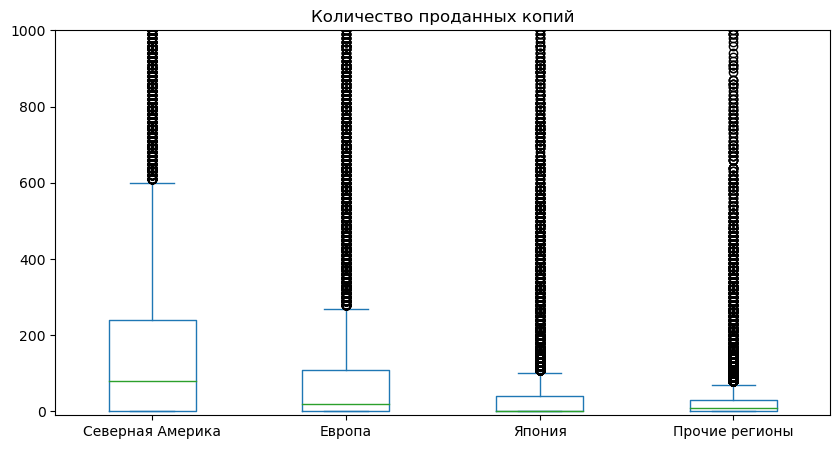

In [16]:
# Сформируем таблицу с описательной статистикой:
descr_stats = pd.DataFrame(index = df['na_sales'].describe().index)
descr_stats['Северная Америка'] = df['na_sales'].describe()
descr_stats['Европа'] = df['eu_sales'].describe()
descr_stats['Япония'] = df['jp_sales'].describe()
descr_stats['Прочие регионы'] = df['other_sales'].describe()
display(descr_stats)

# Построим диаграммы размаха:
ax = df.loc[:, 'na_sales':'other_sales'].plot(kind = 'box',
                                        ylim = (-10,1000),
                                        figsize = (10,5),
                                        title = 'Количество проданных копий'
                                       )
ax.set_xticklabels(['Северная Америка','Европа','Япония','Прочие регионы']);

Видим, что для 75% наблюдений количество проданных копий не превышает 240 тыс. (для Северной Америки, меньшие пороги - для других регионов). Для Японии вообще отстутствуют продажи для половины наблюдений. При этом рекорды по продажам превосходят 40 млн копий. Рассмотрим топ-10 игр по общему количеству продаж:

In [17]:
display(df.sort_values('total_sales', ascending=False).head(10))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41360,28960,3770,8450,76.0,8.0,E,82540
1,Super Mario Bros.,NES,1985,Platform,29080,3580,6810,770,NaN,NaN,Undefined,40240
2,Mario Kart Wii,Wii,2008,Racing,15680,12760,3790,3290,82.0,8.3,E,35520
3,Wii Sports Resort,Wii,2009,Sports,15610,10930,3280,2950,80.0,8.0,E,32770
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11270,8890,10220,1000,NaN,NaN,Undefined,31380
5,Tetris,GB,1989,Puzzle,23200,2260,4220,580,NaN,NaN,Undefined,30260
6,New Super Mario Bros.,DS,2006,Platform,11280,9140,6500,2880,89.0,8.5,E,29800
7,Wii Play,Wii,2006,Misc,13960,9180,2930,2840,58.0,6.6,E,28910
8,New Super Mario Bros. Wii,Wii,2009,Platform,14440,6940,4700,2240,87.0,8.4,E,28320
9,Duck Hunt,NES,1984,Shooter,26930,630,280,470,NaN,NaN,Undefined,28310


Заметим, что это действительно игры-рекордсмены в количестве проданных копий, т.е. ошибки в данных нет. При этом, 4 из топ-10 игр выпущены на платформах, по которым не отслеживается рейтинг.

Найдем количество игр, общие продажи которых превышают 10 млн копий (мегапопулярные проекты) либо наоборот, не превосходят 10 тыс. копий (аутсайдеры):

In [18]:
# Агрегируем данные о глобальных продажах игр на всех платформах:
games_total_sales = df.pivot_table(index='name', values='total_sales', aggfunc='sum')

print('Количество мегапопулярных игр:', len(games_total_sales.query('total_sales >= 10000')))
print('Количество игр-аутсайдеров:', len(games_total_sales.query('total_sales <= 10')))

Количество мегапопулярных игр: 97
Количество игр-аутсайдеров: 516


Видим, что "полярных" игр (мегапопулярных либо наоборот, совсем неудачных) немного от общего количества игр в выборке.

### Контроль размера выборки

Теперь, когда пропуски заполнены там, где это оправдано, можно удалить строки, в которых не указан год выхода игры (ок. 140 строк) и возможные явные дубликаты, появившиеся в процессе предобработки. Проконтролируем, насколько уменьшится выборка после этих действий: 

In [19]:
df = df.dropna(subset=['year_of_release'])
df = df.drop_duplicates()

final_size = len(df)
print('Выборка уменьшилась на {}%.'.format(round((initial_size/final_size - 1)*100)))

Выборка уменьшилась на 1%.


### Вывод

На этапе предобработки данных были выполнены следуюшие шаги:
* заполнены пропуски в дате выхода игры, оценке пользователей и критиков, а также возрастном рейтинге на основании данных о той же игре на других платформах (при наличии). В большинстве случаев данные об играх с других платформ оказались недоступны. Спрогнозировать рейтинги в зависимости от других имеющихся данных, напр., от жанра, не представляется целесообразным, т.к. такое "усреднение" исказит распределение признаков и повлияет на анализ зависимости популярности игры от рейтинга. Как результат, выборка содержит ок. 40-50% пропусков в данных о рейтингах игры, что существенно снижает качество анализа.
* дубликатов в написании жанров, платформ и возрастного рейтинга выявлено не было.

В результате предобработки выборка сократилась на 1%, что является допустимым.

Выборка охватывает игры, вышедшие с 1980 по 2016 г. За этот период индустрия претерпела множество изменений, поэтому для прогноза на следующий период необходимо выбрать релевантные данные.

## Анализ
### Выбор периода для исследования

Рассмотрим распределение количества выпускаемых игр по годам выхода:

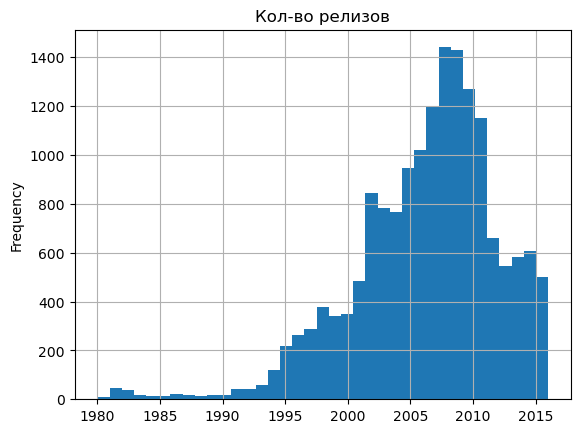

In [20]:
df['year_of_release'].plot(kind='hist', bins=37, grid=True, title='Кол-во релизов');

Заметно, что количество выпускаемых игр существенно возрастает к 1995 г. по сравнению с 1990 г. Вероятно, это связано с развитием Интернета и расширением рынка консолей. Затем происходит относительно плавный рост до начала 2000-х и лавинообразный рост в 2000-е. Пик по количеству вышедших игр приходится на 2008-2009 гг. (ок. 1 350 игр за год). После количество релизов плавно сокращается и скачкообразно падает в 2011 г. до уровня ок. 600 игр и показатель не поднимается выше этого порога до конца периода наблюдений. Возможно, проекты стали более масштабными с укрупнением студий и/ли стало появляться больше эксклюзивов для платформ (в числе релизов учитываются отдельно выходы игры на каждой платформе).

Таким образом, период до 2000 г. точно не показателен для нашего анализа. Период с 2000 г. по 2011 г., возможно, тоже не характеризует текущую индустрию. Требуется дальнейший анализ.

Теперь проанализируем структуру продаж в разрезе платформ:

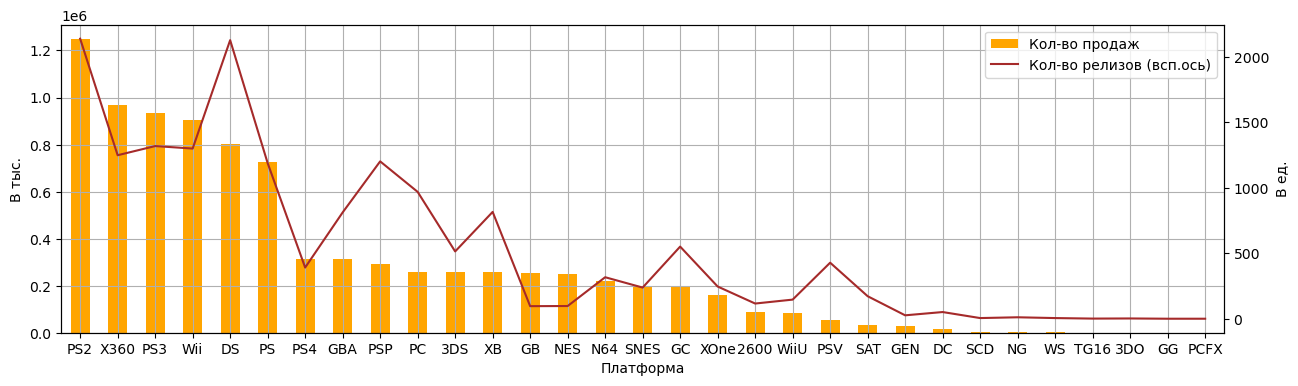

In [21]:
# Агрегируем общие продажи и количество релизов по платформам:
platforms_total_sales = df.pivot_table(index = 'platform', values = 'total_sales', aggfunc = ['sum', 'count'])
platforms_total_sales.columns = ['sales', 'releases']
platforms_total_sales = platforms_total_sales.sort_values('sales', ascending=False)

# Визуализируем актуальные данные:
ax = (platforms_total_sales['sales'].plot(kind='bar', 
                                     figsize=(15, 4), 
                                     ylabel = 'В тыс.',
                                     label = 'Кол-во продаж',
                                     color = 'orange',
                                     legend=True)
          )
(platforms_total_sales['releases'].plot(kind='line', 
                                    secondary_y=True,
                                    grid=True,
                                    label='Кол-во релизов (всп.ось)',
                                    mark_right=False,
                                    xlabel='Платформа',
                                    legend=True,
                                    color='brown')
)
ax.right_ax.set_ylabel('В ед.')
plt.show()

С большим отрывом по общему числу продаж лидирует PlayStation 2 - более 1,2 млрд проданных копий. В пятерке лидеров также Xbox 360, PS3, Nintendo Wii и DS (800 - 900 млн копий). ПК на десятом месте (ок. 250  млн копий). При этом рейтинг платформ по количеству вышедших игр несколько иной - первое место делят PS2 и DS (ок. 2 100 тайтлов), ПК на 8м месте (ок. 1 000 тайтлов). Это говорит о том, что разные платформы характеризуются разной концентрацией игр в продаже и количеством эксклюзивов.

Рассмотрим распределения продаж по годам выхода игр на топ-6 платформах и отдельно для ПК. 

Стоит однако помнить, что речь о кумулятивных продажах, т.е. продажи игры, напр., 2010 г., может продолжаться и сейчас. Кроме того, не совсем корректно сопоставлять продажи более свежих игр и более ранних игр. Для корректного сопоставления нужно провести like-for-like анализ, однако разрез имеющихся данных не позволяет этого сделать. Поэтому, помимо количества проданных копий, будем ориентироваться и на количество релизов на платформе по годам.

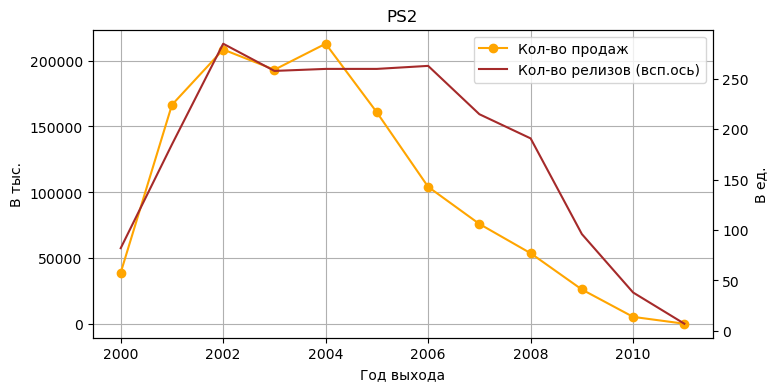

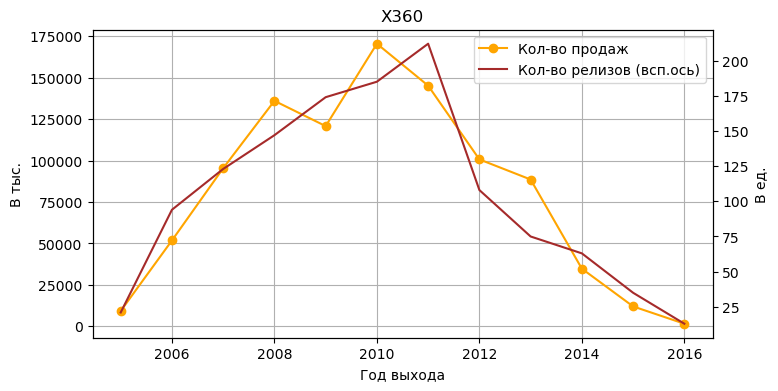

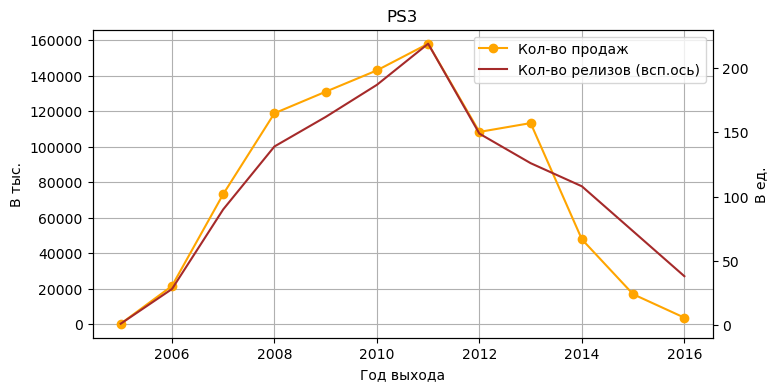

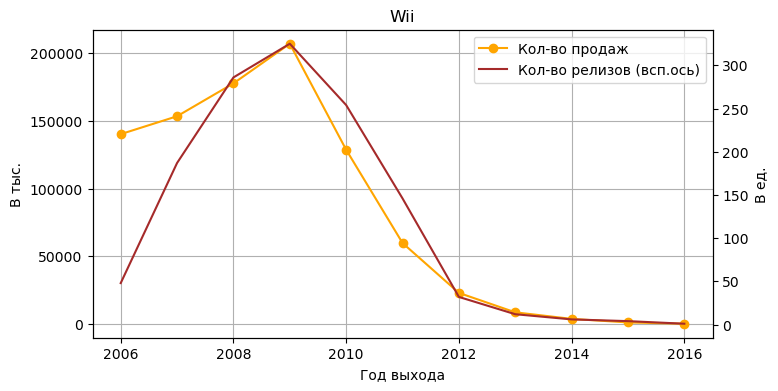

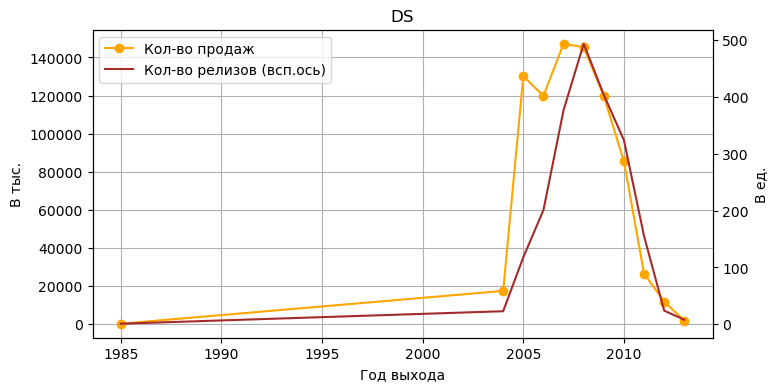

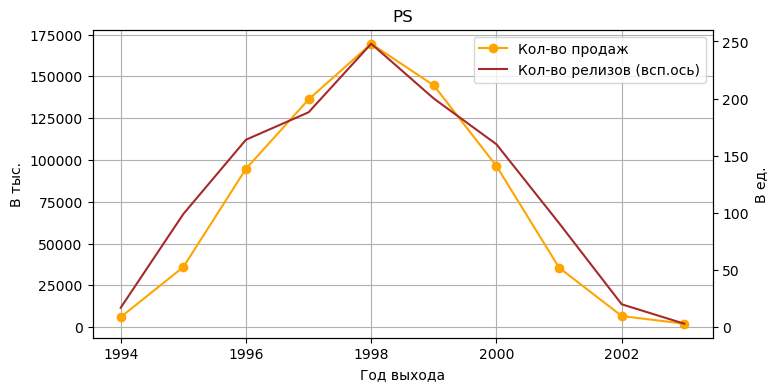

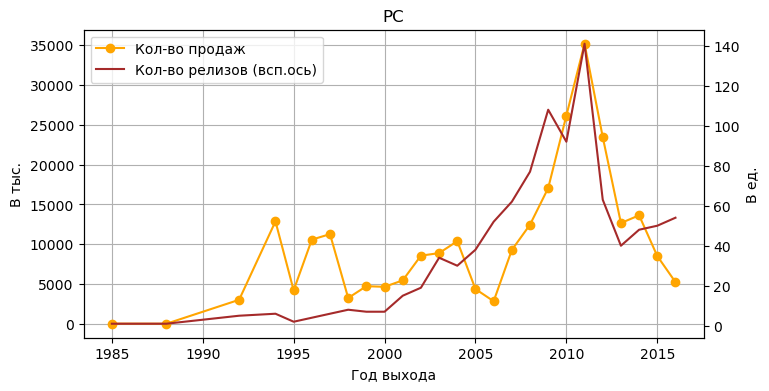

In [22]:
# Создаем список с топ-6 платформами по общим продажам и ПК:
top_platforms = list(platforms_total_sales.head(6).index)
top_platforms.append('PC')

# Создаем графики продаж и кол-ва релизов для каждой из топ-6 платформ:
for item in top_platforms:
    pivot = (df.query('platform == @item').
             pivot_table(index='year_of_release', values='total_sales', aggfunc=['sum', 'count']))
    pivot.columns = ['sales', 'releases']
    ax = (pivot['sales'].plot(kind='line', 
                              figsize=(8, 4), 
                              ylabel = 'В тыс.',
                              label = 'Кол-во продаж',
                              legend=True,
                              style='-o',
                              color='orange')
          )
    (pivot['releases'].plot(kind='line', 
                         secondary_y=True,
                         grid=True,
                         legend=True,
                         label='Кол-во релизов (всп.ось)',
                         mark_right=False,
                         xlabel='Год выхода',
                         title= item,
                         color='brown'))
    ax.right_ax.set_ylabel('В ед.')
    plt.show()

Из графиков видно, что активный период новых релизов на консолях составляет в основном 10 лет. Явное исключение - DS, однако и по ней пиковые продажи пришлись на игры, вышедшие в пределах ок. 8 лет (2005-2012 гг.). Таким образом, можно считать, что "период активности" для консоли составляет в основном 10 лет.

Ситуация для ПК иная - активность релизов в целом повторяет общий тренд. Количество проданных копий демонстрирует всплески по сравнению с количествоми релизов за счет продаж популярных тайтлов. 

Таким образом, исходя из динамики числа релизов, наиболее актуальным можно считать период с 2011 г. после перелома тренда в сторону понижения.

In [23]:
df_relevant = df.query('year_of_release >= 2012').reset_index(drop=True)
pd.DataFrame(round(df_relevant.isna().mean()*100, 3)).style.background_gradient()

,0
name,0.000000
platform,0.000000
year_of_release,0.000000
genre,0.000000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
critic_score,41.221000
user_score,39.496000


При отсечении нерелевантных данных доля пропусков в оценках критиков и пользователей, а также возрастном рейтинге существенно не изменилась - это свидетельствует о том, что причины пропусков не связаны с периодом выхода игр, а скорее имеют либо техническую природу, либо связаны с тиражом игр и т.д.

### Анализ актуального периода

#### Исследование популярности платформ

Теперь, когда определено поле актуальных данных, рассмотрим распределение продаж по платформам на текущий момент:

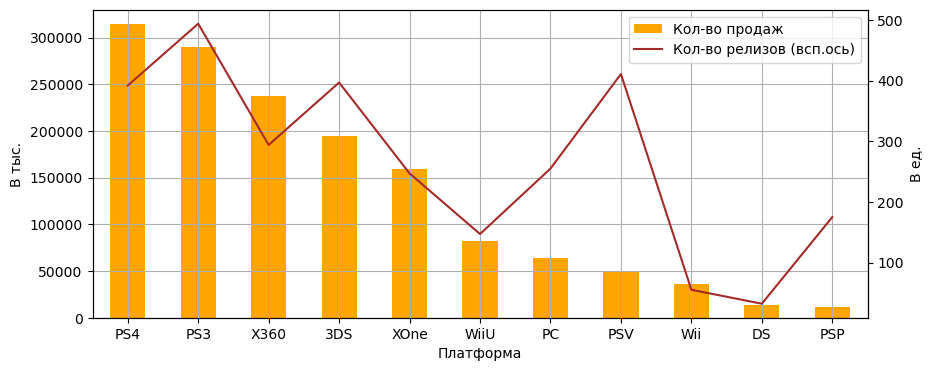

In [24]:
# Агрегируем общие продажи по платформам на актуальных данных:
platforms_actual_sales = df_relevant.pivot_table(index = 'platform', values = 'total_sales', aggfunc = ['sum', 'count'])
platforms_actual_sales.columns = ['sales', 'releases']
platforms_actual_sales = platforms_actual_sales.sort_values('sales', ascending=False)

# Визуализируем актуальные данные:
ax = (platforms_actual_sales['sales'].plot(kind='bar', 
                             grid=True, 
                             figsize=(10, 4),
                             ylabel = 'В тыс.',
                             label = 'Кол-во продаж',
                             legend=True,
                             color = 'orange')
          )
(platforms_actual_sales['releases'].plot(kind='line', 
                                    secondary_y=True,
                                    grid=True,
                                    legend=True,
                                    label='Кол-во релизов (всп.ось)',
                                    mark_right=False,
                                    xlabel='Платформа',
                                    color='brown')
)
ax.right_ax.set_ylabel('В ед.')
plt.show()

* По **количеству проданных копий** лидирует PS4 (чуть более 300 млн копий). На втором месте - PS3 (чуть менее 300 млн копий). В топ-5 также консоли X360, 3DS, XOne. ПК на 7м месте (ок. 60 млн копий).
* По **количеству релизов** на первом месте - PS3 (ок. 500 тайтлов), на втором - PSV (немного более 400 тайтлов, 8е место по количеству продаж). Третье и четвертое место делят 3DS и PS4 (почти 400 игр). ПК на 6м месте (ок. 250 игр).

Рассмотрим динамику количества продаж и релизов по годам:

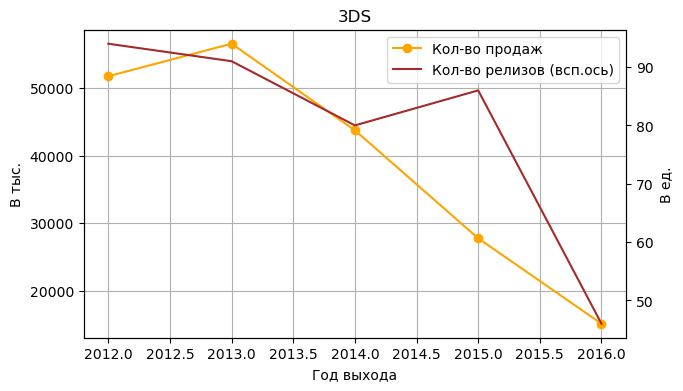

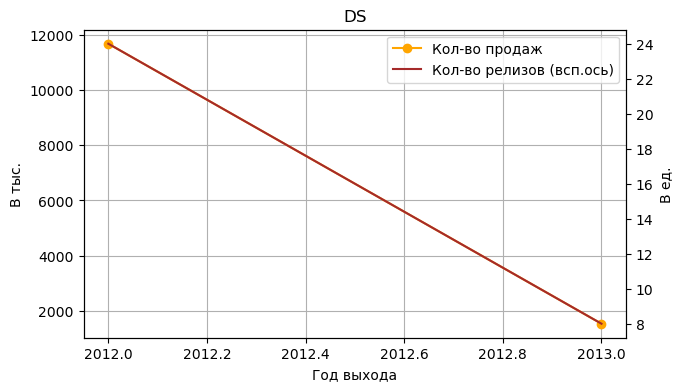

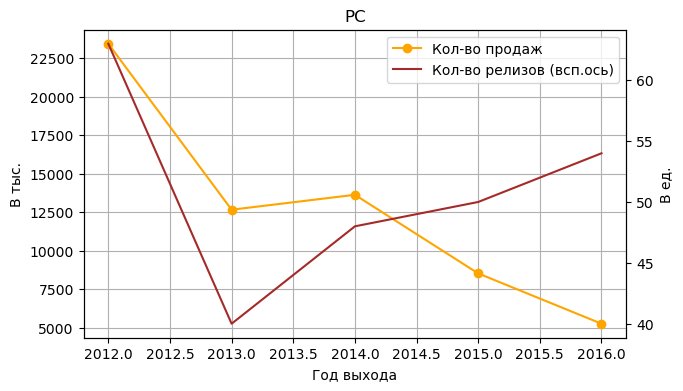

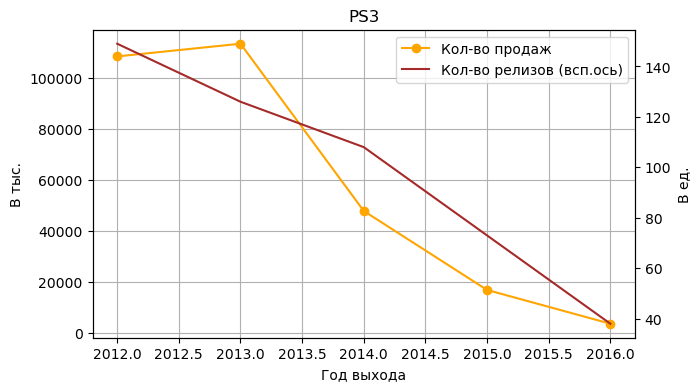

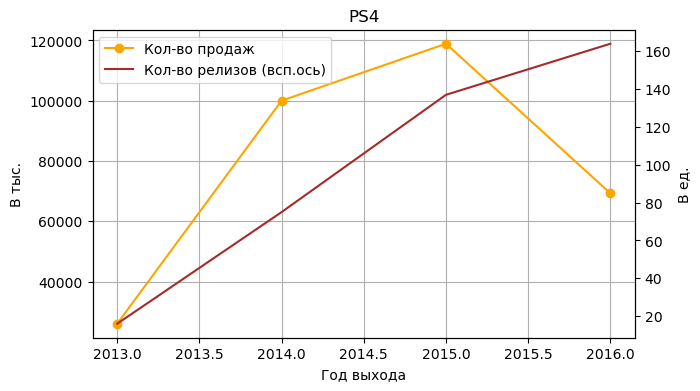

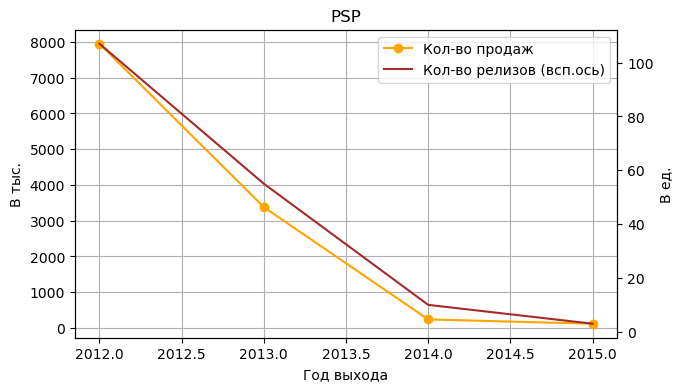

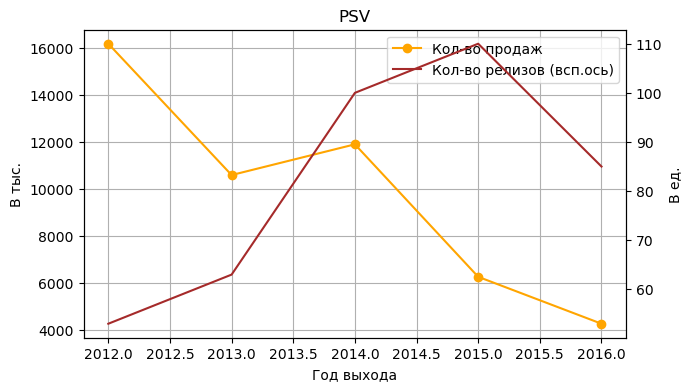

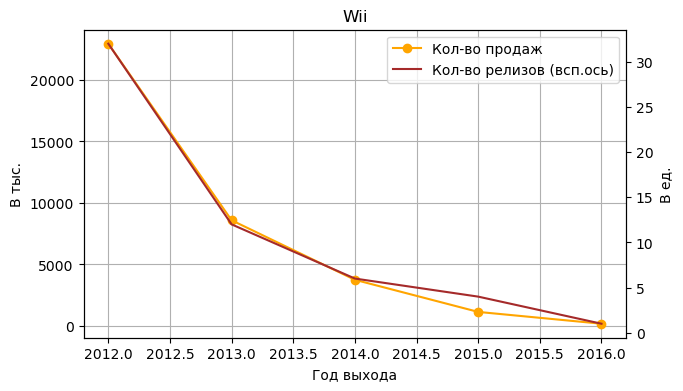

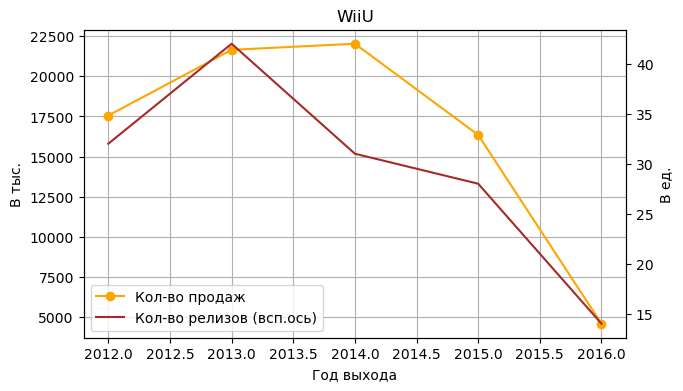

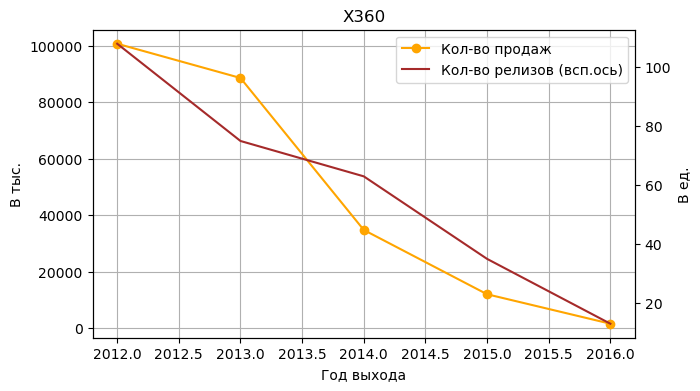

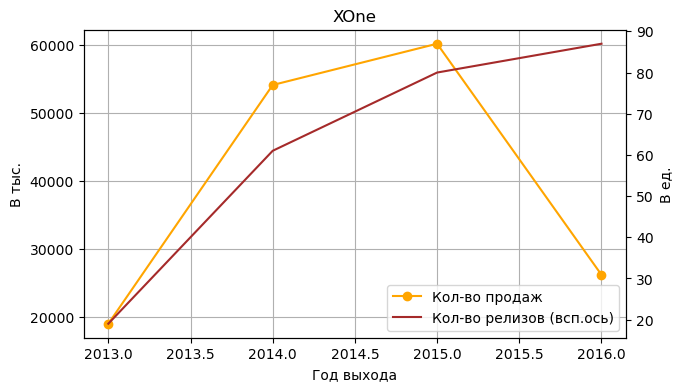

In [25]:
# Создаем список с интересующими нас платформами:
top_platforms = list(platforms_actual_sales.index)

# Создаем графики продаж и кол-ва релизов для интересующих платформ:
for pl_name, pl_slice in df_relevant.query('platform in @top_platforms').groupby('platform'):
    pivot = pl_slice.pivot_table(index='year_of_release', values='total_sales', aggfunc=['sum', 'count'])
    pivot.columns = ['sales', 'releases']
    ax = (pivot['sales'].plot(kind='line', 
                              figsize=(7, 4), 
                              ylabel = 'В тыс.',
                              label = 'Кол-во продаж',
                              legend=True,
                              style='-o',
                              color='orange')
          )
    (pivot['releases'].plot(kind='line', 
                            secondary_y=True,
                            grid=True,
                            legend=True,
                            title= pl_name,
                            label='Кол-во релизов (всп.ось)',
                            mark_right=False,
                            xlabel='Год выхода',
                            color='brown'))
    ax.right_ax.set_ylabel('В ед.')
    plt.show()

* Для платформ **"старого" поколения** (PS3, Xbox 360, DS, Wii, PSP) наблюдалось падение числав релизов и продаж.
* Для **PS4 и Xbox One**, вышедших в 2013 г., заметен рост числа релизов при колебаниях продаж от года к году. Т.е. эти консоли в рамках анализируемого периода находились в первой половине своего жизненного цикла. 
* Динамика для **3DS и WiiU** (на рынке с 2011 и 2012 гг. соответсвенно) похожа: на анализируемом периоде наблюдается падение продаж и количества релизов (возможны небольшие колебания).* Для **PSV** наблюдался рост релизов до 2015 г. при падении количества проданных копий за тот же период. Число релизов упало в 2016 г. 
* **ПК** демонстрирует рост числа релизов с 2013 г., который, однако, не приводит к увеличению числа продаж.

Таким образом, наиболее перспективными выглядят  консоли "нового" поколения PS4 и Xbox One. Также следует обратить внимание на ПК (динамика количества продаж не обязательно свидетельствует о снижении доходов от продаж, необходимо дополнительное исследование).

#### Анализ тиражей по платформам

Рассмотрим характеристики тиражей тайтлов, выпускаемых на той или иной платформе:

In [26]:
# Сформируем описательную статистику для интересующих платформ:
descr_stats = pd.DataFrame(index = df_relevant['total_sales'].describe().index)
for pl_name, pl_slice in df_relevant.query('platform in @top_platforms').groupby('platform'):
    descr_stats[pl_name] = pl_slice['total_sales'].describe()
display(descr_stats.transpose().sort_values('count', ascending=False))

,count,mean,std,min,25%,50%,75%,max
PS3,494.0,586.457490,1461.448405,10.0,50.0,200.0,610.0,21050.0
PSV,411.0,119.659367,203.011187,10.0,20.0,50.0,120.0,1960.0
3DS,397.0,491.209068,1385.416485,10.0,40.0,110.0,320.0,14600.0
PS4,392.0,801.377551,1609.456276,10.0,60.0,200.0,730.0,14630.0
X360,294.0,807.891156,1706.880167,10.0,100.0,310.0,870.0,16270.0
PC,255.0,249.058824,490.148516,10.0,30.0,80.0,240.0,5140.0
XOne,247.0,645.020243,1036.138812,10.0,60.0,220.0,685.0,7390.0
PSP,175.0,66.800000,73.594415,10.0,20.0,40.0,90.0,360.0
WiiU,147.0,559.115646,1058.835575,10.0,80.0,220.0,525.0,7090.0
Wii,55.0,665.454545,1157.205795,10.0,65.0,180.0,790.0,6760.0


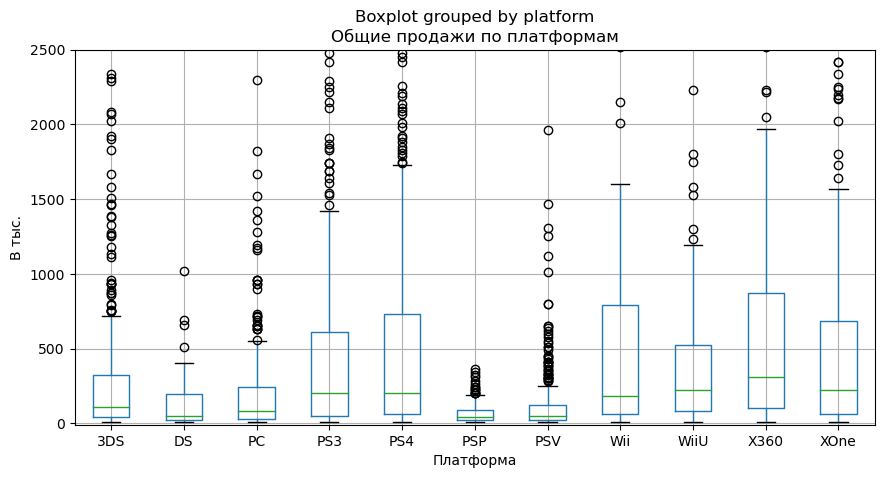

In [27]:
# Построим диаграммы размаха:
ax = df_relevant.boxplot(column='total_sales',
                         by='platform',
                         figsize = (10, 5))

ax.set_title('Общие продажи по платформам')
ax.set_ylim(-10, 2500)
ax.set_ylabel('В тыс.')
ax.set_xlabel('Платформа')
plt.show()

* Основные конкуренты среди консолей "нового" поколения - PlayStation 4 и Xbox One - довольно похожи по типичным тиражам (первый квартиль - 60 тыс. копий, медиана - 200-220 тыс. копий, третий квартиль - 680-730 тыс.). Однако максимальный тираж на PS4 почти в 2 раза выше, чем на XOne (`Call of Duty: Black Ops 3`: 14,6 млн копий против 7,4 млн копий).
* PSV демонстрирует второй по выборке результат по количеству игр (ок. 400), однако типичные тиражи совсем небольшие - медиана в 50 тыс. копий, третий квартиль - 120 тыс. копий.
* Среди консолей "старого" поколения (X360, PS3, Wii, DS, PSP) выделяется Xbox c медианным тиражом в 310 тыс. копий (лидер по всем платформам). При этом максимальный тираж по всей выборке на PS3: `GTA V` с более 21 млн копий против от 16 млн копий на X360. PS3 и Wii похожи - по типичным тиражам (медиана 200 и 180 тыс. копий, третий квартиль - 610 и 525 тыс. копий). Однако стоит учесть разницу в количестве тайтлов - ок. 500 для PS3 и всего 55 для Wii.  Типичные тиражи DS и PSP небольшие (сопоставимы с PSV).
* Типичный тираж для ПК сопоставим с DS: медиана ок. 80 тыс. копий, крупным считается релиз от 500 тыс. копий.

#### Влияние оценок на число продаж

Построим диаграммы рассеяния по всем платформам, показывающие взаимосвязь между оценками критиков и пользователей и количеством проданных копий. Для уменьшения разброса "усредним" значения продаж в разрезе оценок:

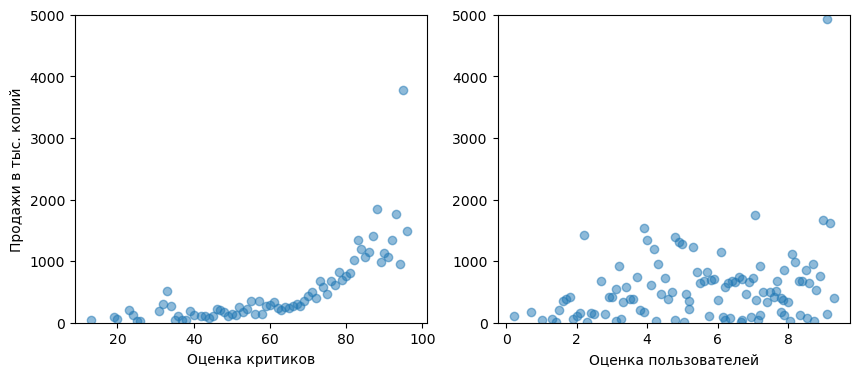

In [28]:
fig, axs = plt.subplots(1,2, figsize = (10, 4))
pivot = (df_relevant.pivot_table(index='critic_score', values='total_sales')) # усредняем продажи в разрезе оценок критиков
axs[0].scatter(x=pivot.index, 
               y=pivot['total_sales'], alpha=0.5);
axs[0].set_ylabel('Продажи в тыс. копий');
axs[0].set_ylim(0,5000)
axs[0].set_xlabel('Оценка критиков');
pivot = (df_relevant.pivot_table(index='user_score', values='total_sales')) # усредняем продажи в разрезе оценок пользователей
axs[1].scatter(x=pivot.index, 
               y=pivot['total_sales'], alpha=0.5);
axs[1].set_xlabel('Оценка пользователей');
axs[1].set_ylim(0,5000);

* **Оценка критиков**: заметно, что продажи по-разному реагируют на оценку в зависимости от того, в какой зоне лежит оценка: продажи начинают сильно расти при росте оценки на участке (70-100). На диапазоне оценки (0-70) также заметен рост количества продаж, однако гораздо более пологий. Т.е. эластичность продаж к оценке критиков существенно больше при высоких оценках.
* **Оценка пользователей**: явного тренда не прослеживается, что противоречит здравому смыслу. Возможно, сказывается влияние разных культур пользователей, характерных для разных платформ, либо не учитывавется стоимость игр (проекты с более высокими отзывами более дорогие) и т.п.

Для примера рассмотрим данные для одной платформы, например, PS4.

Из данных все еще нельзя сделать вывод. Попробуем усреднить данные и изобразить тренд по средним продажам.

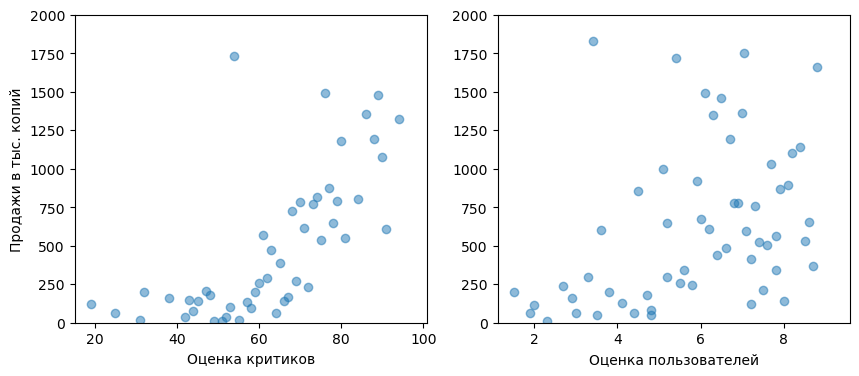

In [29]:
# Построим диаграммы рассеяния для PS3:
fig, axs = plt.subplots(1,2, figsize = (10, 4))
pivot = (df_relevant.query('platform == "PS4"').
         pivot_table(index='critic_score', values='total_sales')) # усредняем продажи в разрезе оценок критиков
axs[0].scatter(x=pivot.index, 
               y=pivot['total_sales'], alpha=0.5);
axs[0].set_ylabel('Продажи в тыс. копий');
axs[0].set_ylim(0,2000)
axs[0].set_xlabel('Оценка критиков');
pivot = (df_relevant.query('platform == "PS4"').
         pivot_table(index='user_score', values='total_sales')) # усредняем продажи в разрезе оценок пользователей
axs[1].scatter(x=pivot.index, 
               y=pivot['total_sales'], alpha=0.5);
axs[1].set_xlabel('Оценка пользователей');
axs[1].set_ylim(0,2000);

* **Оценка критиков**: аналогично общей картине.
* **Оценка пользователей**: разброс количества проданных копий от оценки пользователей существенно больше, чем от оценки критиков. Возможно, это объясняется пропусками в данных. Заметен положительный тренд, однако четкой тенденции не наблюдается.

Рассчитаем коэффициенты корреляции между глобальными продажами и оценками критиков и пользователей:

In [30]:
df_relevant.query('platform == "PS4"')[['critic_score', 'user_score', 'total_sales']].corr(method='spearman')

,critic_score,user_score,total_sales
critic_score,1.000000,0.463522,0.51467
user_score,0.463522,1.000000,0.00941
total_sales,0.514670,0.009410,1.00000


Видим, что взаимосвязь продаж с оценками критиков положительная средней силы (+0,51), с оценкамии пользователей - практически отсутсвует. Возможно, относительно невысокий коэффициент корреляции между оценкой критиков и продажами связан с неравномерным воздействием фактора (см. выше). При этом обнаруживается средней силы взаимосвязь между оценкой критиков и оценкой пользователей.

Попробуем проверить устойчивость выводов для другой платформы - ПК. Возможно, поведение пользователей ПК отличается от пользователей консоли.

,critic_score,user_score,total_sales
critic_score,1.000000,0.433563,0.390124
user_score,0.433563,1.000000,-0.046733
total_sales,0.390124,-0.046733,1.000000


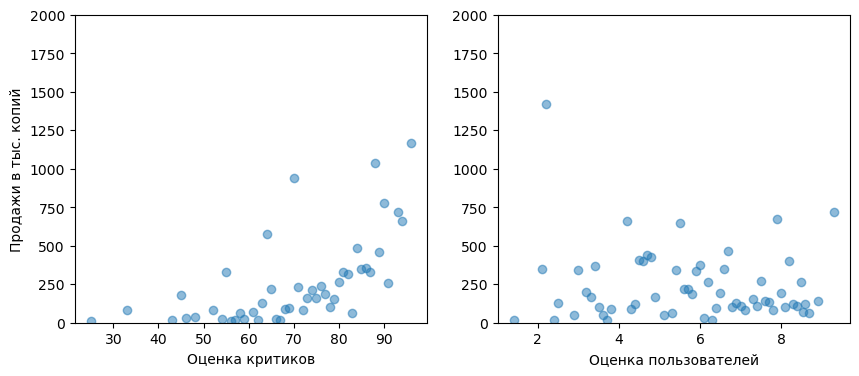

In [31]:
# Построим диаграммы рассеяния для ПК:
fig, axs = plt.subplots(1,2, figsize = (10, 4))
pivot = (df_relevant.query('platform == "PC"').
         pivot_table(index='critic_score', values='total_sales')) # усредняем продажи в разрезе оценок критиков
axs[0].scatter(x=pivot.index, 
               y=pivot['total_sales'], alpha=0.5);
axs[0].set_ylabel('Продажи в тыс. копий');
axs[0].set_ylim(0,2000)
axs[0].set_xlabel('Оценка критиков');
pivot = (df_relevant.query('platform == "PC"').
         pivot_table(index='user_score', values='total_sales')) # усредняем продажи в разрезе оценок пользователей
axs[1].scatter(x=pivot.index, 
               y=pivot['total_sales'], alpha=0.5);
axs[1].set_xlabel('Оценка пользователей');
axs[1].set_ylim(0,2000);

# Рассчитаем коэффициенты корреляции:
display(df_relevant.query('platform == "PC"')[['critic_score', 'user_score', 'total_sales']].corr(method='spearman'))

Для ПК взаимосвязь между факторами еще слабее: +0.4 для оценки критиков, -0.05 для оценки пользователей. Можно сказать, что оценка пользователей не оказывает влияние на продажи, оценка критиков имеет влияние на продажи только на отметках выше 80.

Таким образом, влияние оценок критиков и пользователей на количество проданных копий неочевидно и разнится в зависимости от платформ. Оценка критиков способствует росту продаж только на высоких значениях (выше 70). Из этого можно заключить, что на количество продаж в большей мере, чем оценки, оказывают влияние факторы, не отраженные в исходных данных, напр., стоимость игры, число активных пользователей и т.п.

Также обращаем внимание, что выводы могут быть скорректированы при улучшении качества данных (ок. 40% данных содержат пропуски в оценках пользователей и критиков).



#### Исследование популярности жанров

Рассмотрим распределения количества проданных копий и числа релизов по жанрам:

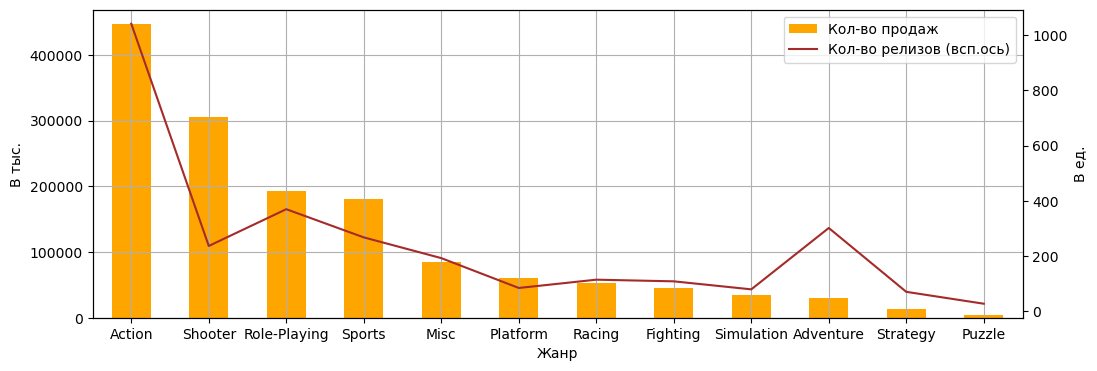

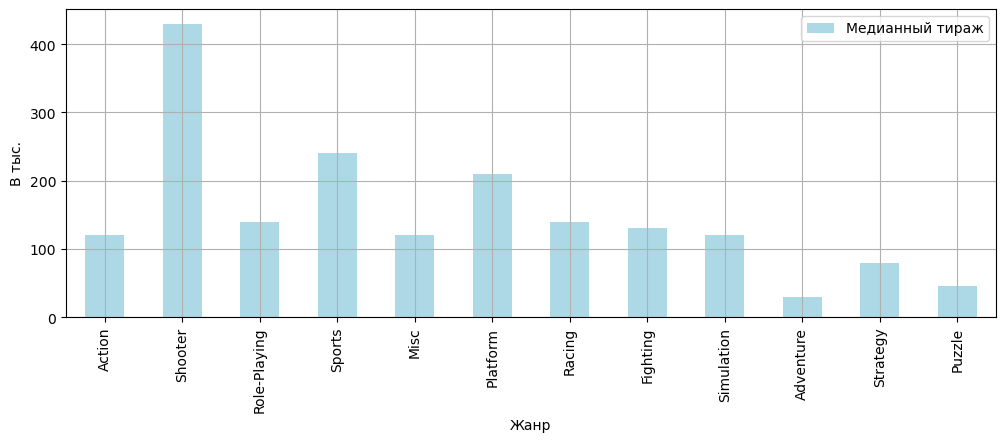

In [32]:
# Агрегируем продажи и количество релизов по жанрам:
genres_actual_sales = df_relevant.pivot_table(index='genre', values='total_sales', aggfunc=['sum', 'count', 'median'])
genres_actual_sales.columns = ['sales', 'releases', 'median_copies']
genres_actual_sales = genres_actual_sales.sort_values('sales', ascending = False)

# Визуализируем актуальные данные:
ax = (genres_actual_sales['sales'].plot(kind='bar', 
                             grid=True, 
                             figsize=(12, 4), 
                             ylabel = 'В тыс.',
                             label = 'Кол-во продаж',
                             legend=True,
                            color='orange')
          )
(genres_actual_sales['releases'].plot(kind='line', 
                                    secondary_y=True,
                                    grid=True,
                                    legend=True,
                                    label='Кол-во релизов (всп.ось)',
                                    mark_right=False,
                                    xlabel='Жанр',
                                    color='brown')
)
ax.right_ax.set_ylabel('В ед.')
plt.show()
(genres_actual_sales['median_copies'].
          plot(kind='bar', 
             grid=True, 
             color = 'lightblue',
             figsize=(12, 4),
             legend=True,
             label = "Медианный тираж",
             xlabel='Жанр',
             ylabel = 'В тыс.')
          )
plt.show()

Лидером как по числу продаж, так и по количеству игр с большим отрывом является жанр Action (более 400 млн копий по более 1000 проектам). Также в четверку лидеров по количеству проданных копий входят шутеры, спорт и ролевые игры. 

Любопытно, что шутеры достигают объема продаж спортивных игр при меньшем числе тайтлов. Вообще шутеры являются лидерами по медианному тиражу игры (более 400 тыс. копий). Также отностительно высокие медианные тиражи демонстрируют спортивные игры и  платформеры. Аутсайдерами по среднему тиражу являются приключенческие игры (хотя число игр сопоставимо с ролевыми играми) и головоломки.


### Портреты пользователей разных регионов

Рассмотрим различия в предпочтениях пользователей разных регионов. Для начала проанализируем распределение продаж по регионам:

Северная Америка    593300.0
Европа              509180.0
Япония              192820.0
Прочие регионы      156780.0
dtype: float64

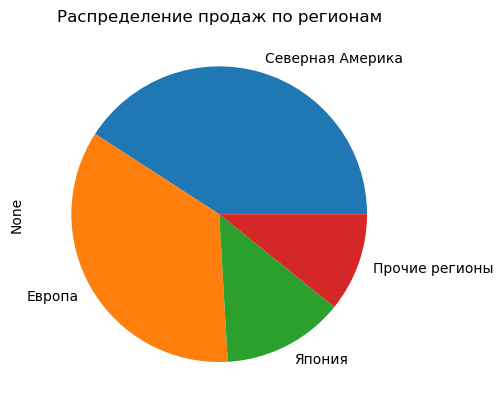

In [33]:
# Отразим доли регионов в общих продажах:
sales_dist = pd.Series(index=['Северная Америка', 'Европа','Япония', 'Прочие регионы'])
sales_dist['Северная Америка'] = df_relevant['na_sales'].sum()
sales_dist['Европа'] = df_relevant['eu_sales'].sum()
sales_dist['Япония'] = df_relevant['jp_sales'].sum()
sales_dist['Прочие регионы'] = df_relevant['other_sales'].sum()
sales_dist.plot(kind='pie', title = 'Распределение продаж по регионам')
display(sales_dist)
plt.show()

Видим, что доли Северной Америки и Европы примерно равны (35-40%). На Японию приходится примерно 13% общемировых продаж. Найдем наиболее популярные платформы среди пользователей разных регионов:

In [34]:
print('Топ-5 популярных платформ:')
# Создаем датафрейм для визуализации:
preferred_platforms = pd.DataFrame(index=[1,2,3,4,5])
regions = ['na_sales', 'eu_sales', 'jp_sales']
# Получаем данные для регионов:
for region in regions:
    pivot = (df_relevant.
             pivot_table(index='platform', values=region, aggfunc='sum'). #агрегируем продажи по платформам
             sort_values(region, ascending=False)) # сортируем по убыванию 
    pivot[region+'_%'] = round(pivot[region] / pivot[region].sum() *100, 1) # находим доли от общего
    pivot[region+'_platf'] = pivot.index
    pivot = pivot.head() # оставляем топ-5
    pivot.index = [1,2,3,4,5] # переопредеяем индексы для корректного переноса в финальную таблицу
    preferred_platforms[region] = pivot[region+'_platf']
    preferred_platforms[region+'_%'] = pivot[region+'_%']
# Переназовем колонки датафрейма для визуализации:
preferred_platforms.columns = ['Сев. Америка','Доля, %', 'Европа', 'Доля, %', 'Япония', 'Доля, %']
display(preferred_platforms)

Топ-5 популярных платформ:


,Сев. Америка,"Доля, %",Европа,"Доля, %",Япония,"Доля, %"
1,X360,23.7,PS4,27.7,3DS,45.5
2,PS4,18.3,PS3,21.1,PS3,18.3
3,PS3,17.5,X360,14.7,PSV,10.9
4,XOne,15.7,XOne,10.1,PS4,8.3
5,3DS,9.4,3DS,8.4,WiiU,6.7


* Набор топ-5 платформ в Северной Америке и Европе совпадает, хотя порядок различен: в Америке лидером является X360 (24%), в Европе она находится на 3м месте. Европейские лидеры - PlayStation 4 и 3 - делят второе и третье место в Америке.
* Структура топ-5 платформ в Японии существенно отличается: на первом месте Nintendo 3DS (почти половина от продаж региона), на втором месте - PS3. PSV занимает в Японии третье место, хотя вообще не вошла в топ-5 для Америки и Европы.

Заметим, что концентрированность предпочтений в Японии выше: на первое место приходится 45% общего числа продаж против 24-28% в Европе и Северной Америке.

ПК не попал в топ-5 ни в одном регионе. Возможно, различия в рейтинге платформ по регионам могут быть связаны с ассортиментом предлагаемых игр, и, как первопричина, различиями в социокультурных аспектах.

Теперь проанализируем наиболее популярные в регионах игровые жанры:

In [35]:
print('Топ-5 популярных жанров:')
# Создаем датафрейм для визуализации:
preferred_genres = pd.DataFrame(index=[1,2,3,4,5])
# Получаем данные для регионов:
for region in regions:
    pivot = (df_relevant.query('genre != "Misc"'). # исключаем прочие, т.к. это несопоставимая категория
             pivot_table(index='genre', values=region, aggfunc='sum'). 
             sort_values(region, ascending=False))
    pivot[region+'_%'] = round(pivot[region] / pivot[region].sum() *100, 1)
    pivot[region+'_genre'] = pivot.index
    pivot = pivot.head()
    pivot.index = [1,2,3,4,5]
    preferred_genres[region] = pivot[region+'_genre']
    preferred_genres[region+'_%'] = pivot[region+'_%']
preferred_genres.columns = ['Сев. Америка','Доля, %', 'Европа', 'Доля, %', 'Япония', 'Доля, %']
display(preferred_genres)

Топ-5 популярных жанров:


,Сев. Америка,"Доля, %",Европа,"Доля, %",Япония,"Доля, %"
1,Action,32.5,Action,33.5,Role-Playing,36.4
2,Shooter,26.1,Shooter,23.5,Action,29.4
3,Sports,14.7,Sports,14.3,Simulation,5.8
4,Role-Playing,11.5,Role-Playing,10.1,Fighting,5.3
5,Platform,4.6,Racing,5.7,Shooter,5.1


* Заметно, что вкусы пользователей в Северной Америке и Европе в целом совпадают: самый популярный жанр - экшн (ок. трети всех продаж), шутеры и спорт занимают 2 и 3 места (ок. 25% и 15% соответственно), ролевые игры - 4 место. 

* Совсем иная картина предпочтений у пользователей из Японии: на прервом месте ролевые игры (36%), на втором - экшн (30%). Доли следующих по популярности жанров не превышают 6%.

Теперь рассмотрим склонность пользователей регионов к насилию (оцененную через возрастной рейтинг ESRB). Необходимо учесть, что данные доступны не по всем наблюдениям (доли расчитаны по имеющимся наблюдениям).

In [36]:
# Создаем датафрейм для визуализации:
preferred_rating = pd.DataFrame(index=[1,2,3,4,5])
# Получаем данные для регионов:
for region in regions:
    pivot = (df_relevant.
             pivot_table(index='rating', values=region, aggfunc='sum'). 
             sort_values(region, ascending=False)) 
    pivot[region+'_%'] = round(pivot[region] / pivot[region].sum() *100, 1)
    pivot[region+'_rating'] = pivot.index
    pivot.index = [1,2,3,4,5]
    preferred_rating[region] = pivot[region+'_rating']
    preferred_rating[region+'_%'] = pivot[region+'_%']
preferred_rating.columns = ['Сев. Америка','Доля, %', 'Европа', 'Доля, %', 'Япония', 'Доля, %']
display(preferred_rating)

,Сев. Америка,"Доля, %",Европа,"Доля, %",Япония,"Доля, %"
1,M,40.8,M,40.5,Undefined,53.6
2,E,19.9,E,22.7,E,15.2
3,Undefined,14.0,Undefined,13.8,T,15.1
4,E10+,13.5,E10+,11.7,M,11.7
5,T,11.8,T,11.2,E10+,4.4


* Северная Америка и Европа: как и в случае с жанрами, структура продаж похожа. Наиболее продаваемыми оказались игры для взрослых с высоким уровнем насилия (более 40% продаж в регионах). Ок. 20% приходится на игры для всех. По 14% продаж данные отсутствуют.
* Япония: Нет данных по рейтингу для более половины продаж региона. Вероятно, это связано с тем, что используется другая рейтинговая система. Таким образом, данные по Японии фактически несопоставимы с другими регионами.

Таким образом, портреты пользователей разных регионов выглядят следующим образом:
* В **Северной Америке** предпочитают Xbox (Х360 на первом месте, XOne - на 4м), PlayStation на втором месте. Любимыми жанрами являются экшн, шутеры и спорт. Предпочтение отдается играм с высоким уровнем насилия.
* В **Европе** лидер по продажам - PlayStation (PS4 и PS3 на 1м и 2м местах). В отношении жанров и возрастного контента предпочтнения аналогичны Северной Америке.
* В **Японии** лидирует Nintendo 3DS (почти половина всех продаж), на втором месте PS3. Предпочтение отдается ролевым и экшн-играм. Из имеющихся данных невозможно выделить предпочитаемый по возрастным ограничениям контент, т.к. по более 50% продаж региона информация отсутсвует (скорее всего, поскольку используется другая рейтинговая система).

Для анализа причин, приводящих к различным предпочтениям, необходимы дополнительные исследования: социокультурные, технические (специфика устройства различных консолей), маркетинговые (различия в ассортиментах, эксклюзивах) и т.д.

### Проверка гипотез

В рамках исследования требуется проверить несколько гипотез:

* Средние пользовательские рейтинги платформ XOne и PC одинаковы;
* Средние пользовательские рейтинги жанров Action и Sports разные.

#### Средние пользовательские рейтинги XOne и PC равны

Сформулируем гипотезы следующим образом: 
```
H_0: Средний пользовательсткий рейтинг (user_score) на платформе XOne = Средний пользовательсткий рейтинг (user_score) на платформе PC
H_a: Средний пользовательсткий рейтинг (user_score) на платформе XOne ≠ Средний пользовательсткий рейтинг (user_score) на платформе PC
alpha = 0.05
```

Для целей анализа неважно, чей рейтинг больше, поэтому следует использовать двусторонний тест. Распределение пользовательского рейтинга на одной платформе не влияет на распределение на другой платформе.

In [37]:
#Задаем критерий значимости:
alpha = 0.05

# Формируем выборки и считаем их статистики:
xone = df_relevant[(df_relevant['platform']=="XOne") & ~(df_relevant['user_score'].isna())]['user_score']
pc = df_relevant[(df_relevant['platform']=="PC") & ~(df_relevant['user_score'].isna())]['user_score']

mu_xone = xone.mean()
mu_pc = pc.mean()
sigma_xone = np.std(xone)
sigma_pc = np.std(pc)

print('Кол-во наблюдений в выборке для XOne: {0}, среднее: {1}, станд.отклонение: {2}'.
      format(len(xone), round(mu_xone, 3), round(sigma_xone, 3)))
print('Кол-во наблюдений в выборке для PC: {0}, среднее: {1}, станд.отклонение: {2}'.
      format(len(pc), round(mu_pc, 3), round(sigma_pc, 3)))
print('----------')

# Тестируем гипотезу друсторонним t-тестом на сравнение выборочных средних для независимывх выборок:
results = st.ttest_ind(xone, pc, equal_var = False)

print('p-value:', results.pvalue)                      
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Кол-во наблюдений в выборке для XOne: 206, среднее: 6.617, станд.отклонение: 1.373
Кол-во наблюдений в выборке для PC: 215, среднее: 6.45, станд.отклонение: 1.661
----------
p-value: 0.261055465127316
Не получилось отвергнуть нулевую гипотезу


Таким образом, нам не удалось опровергнуть на уровне значимости 5%, что для генеральных совокупностей средние пользовательские рейтинги двух платформ равны. Возможно, это связано с тем, что Xbox позиционируется как полностью совместимая с ПК платформа, поэтому у них примерно одна аудитория с похожими предпочтениями.

#### Средние пользовательские рейтинги Action и Sports разные

Сформулируем гипотезы следующим образом: 
```
H_0: Средний пользовательсткий рейтинг (user_score) Action игр = Средний пользовательсткий рейтинг (user_score) Sports игр 
H_a: Средний пользовательсткий рейтинг (user_score) Action игр ≠ Средний пользовательсткий рейтинг (user_score) Sports игр 
alpha = 0.05
```

Для целей анализа неважно, чей рейтинг больше, поэтому следует использовать двусторонний тест. Распределение пользовательского рейтинга для игр одного жанра не влияет на распределение для игр другого жанра.

In [38]:
# Формируем выборки и считаем их статистики:
action = df_relevant[(df_relevant['genre']=="Action") & ~(df_relevant['user_score'].isna())]['user_score']
sports = df_relevant[(df_relevant['genre']=="Sports") & ~(df_relevant['user_score'].isna())]['user_score']

mu_action = action.mean()
mu_sports = sports.mean()
sigma_action = np.std(action)
sigma_sports = np.std(sports)

print('Кол-во наблюдений в выборке для Action игр: {0}, среднее: {1}, станд.отклонение: {2}'.
      format(len(action), round(mu_action, 3), round(sigma_action, 3)))
print('Кол-во наблюдений в выборке для Sports игр: {0}, среднее: {1}, станд.отклонение: {2}'.
      format(len(sports), round(mu_sports, 3), round(sigma_sports, 3)))
print('----------')

# Тестируем гипотезу двусторонним t-тестом на сравнение выборочных средних для независимывх выборок:
results = st.ttest_ind(action, sports, equal_var = False)

print('p-value:', results.pvalue)                      
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Кол-во наблюдений в выборке для Action игр: 610, среднее: 6.871, станд.отклонение: 1.369
Кол-во наблюдений в выборке для Sports игр: 221, среднее: 5.413, станд.отклонение: 1.699
----------
p-value: 8.664241498191817e-26
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергается на любом разумном уровне значимости, т.е. мы не отвергаем гипотезу, что для генеральной совокупности рейтинги игр жанра Action и Sports разные.

### Вывод
Для анализа были выбраны данные об играх, вышедших с 2012 по 2016 гг., т.к. этот период характеризует отрасль для 2017 г. по динамике количества релизов.

1) Согласно данным, наиболее **популярными в мире платформами** по количеству продаж в мире являлись PlayStation (4 и 3), на ними - Xbox 360. Количество выпускаемых игр растет для платформ "нового" поколения и ПК, продажи и число релизов консолей "старого" поколения сокращается.

2) Наиболее **популярным жанром** по суммарному числу продаж, так и по количеству игр с большим отрывом является жанр Action (более 400 млн копий по более 1000 проектам). Также в четверку лидеров по количеству проданных копий входят шутеры, спорт и ролевые игры. Лидер по медианному тиражу с большим отрывом - шутеры (более 400 тыс. копий). Аутсайдерами по медианному тиражу являются приключения и головоломки.

3) Затем на основе всей выборки, а также данных конкретных платформ была проанализирована **зависимость числа продаж от оценок крикиков и пользователей**. Имеющиеся данные свидетельствуют о том, что продажи на разных платформах имеют разную чувствительность к оценкам:
* оценки пользователей не оказывают существенного влияния на продажи;
* оценки критиков оказывают среднее (PS4), либо слабое положительное влияние (ПК). При этом степень влияния зависит от самой оценки: при оценках ниже 70 рост оценки ведет к небольшому приросту продаж, выше 70 - темп прироста продаж резко увеличивается. 

Возможно, слабая зависимость продаж от оценок объясняется расходами на маркетинг на этапе предзаказов (рейтинг еще не сформирован), размерами фан-базы франшизы или другими причинами, не влияющими напрямую на рейтинг. Обращаем внимание, что выводы могут быть скорректированы при улучшении качества данных (в ок. 40% наблюдений по оценкам пользователей и критиков имеются пропуски).

4) Далее были сформированы **портреты пользователей** из Северной Америки, Европы и Японии:

* В *Северной Америке* предпочитают Xbox (Х360 на первом месте, XOne - на 4м), PlayStation на втором месте. Любимыми жанрами являются экшн, шутеры и спорт. Предпочтение отдается играм с высоким уровнем насилия.
* В *Европе* лидер по продажам - PlayStation (PS4 и PS3 на 1м и 2м местах). В отношении жанров и возрастного контента предпочтнения аналогичны Северной Америке.
* В *Японии* лидирует Nintendo 3DS (почти половина всех продаж), на втором месте PS3. Предпочтение отдается ролевым и экшн-играм. Из имеющихся данных невозможно выделить предпочитаемый по возрастным ограничениям контент, т.к. по более 50% продаж региона информация отсутсвует (скорее всего, поскольку используется другая рейтинговая система).

Для анализа причин, приводящих к различным предпочтениям, необходимы дополнительные исследования: социокультурные, технические (специфика устройства различных консолей), маркетинговые (различия в ассортиментах, эксклюзивах) и т.д.

5) Кроме того, статистическими методами были **проверены две гипотезы**: 
* Средние пользовательские рейтинги платформ XOne и PC одинаковы;
* Средние пользовательские рейтинги жанров Action и Sports разные.

На основе имеющихся данных нельзя отвергнуть ни одну из них.

## Общий вывод

Цель проекта состояла в выявлении зависимостей между оценкой игры критиками и/ли пользователями на  ее успешность, выраженную в количестве проданных копий. 

Исходная выборка содержала ок. 16 тыс. наблюдений и охватывала период игр, вышедших с 1980 г. по 2016 г. (данные из публичных источников). В информации об оценках и возрастном рейтинге игры имелись пропуски (ок. половины от общего числа наблюдений). При наличии данных пропуски в оценках были заполнены на основе информациии по другим  платформам. Оставшиеся пропуски было решено оставить как есть, т.к. оценку этих показателей нелогично прогнозировать из имеющихся данных. В результате в выборке осталось 30-40% пропусков в данных об оценках и рейтинге ESRB, что могло сказаться на качестве дальнейшего анализа.

Поскольку исходные данные содержали информацию об исторических периодах, не отражающих реалии рынка онлайн-игр на 2017 г., было решено ограничить рассматриваемое поле играми, вышедшими с 2012 по 2016 г.

В результате анализа были получены следующие выводы:

1) Наиболее **популярные платформы** в мире по числу продаж - PS4, PS3 и X360. Рост числа игр заметен на PS4, Xbox One и ПК, в то время как число релизов и продаж на консолях "старого" поколения падает.

2) Наиболее **продаваемый жанр** в мире по числу игр и копий  - экшн (более 400 млн копий для игр. вышедших за 4 года). В топ-3 по числу продаж также шутеры и спорт. Однако медианный тираж наиболее высокий у шутеров (более 400 тыс. копий против ок. 100 тыс.копий для экшн-игр). Наименьший медианный тираж у приключений и головоломок.

3) **Портреты пользователей** для Северной Америки и Европы в целом похожи (предпочтение отдается экшн-играм и шутерам с высоким уровнем насилия. В Северной Америке предпочтительнее Xbox, в Европе PlayStaton). Существенные отличия наблюдаются в Японии: наиболее популярная платформа - Nintendo 3DS (почти половина продаж), жанры - ролевые и экшн-игры. Сопоставить склонность пользователей к насилию  с западными регионами не удалось из-за ограничений в качестве данных (в Японии более популярна другая рейтинговая система).

Для анализа причин, приводящих к различным предпочтениям, необходимы дополнительные исследования: социокультурные, технические (специфика устройства различных консолей), маркетинговые (различия в ассортиментах, эксклюзивах) и т.д.

4) **Зависимость числа продаж от оценок критиков и пользователей** различна от платформы к платформе:
* оценки пользователей не оказывают влияния на продажи;
* оценки критиков оказывают среднее (PS4), либо слабое положительное влияние (ПК). При этом при оценках ниже 70 рост оценки ведет к небольшому приросту продаж, выше 70 - темп прироста продаж резко увеличивается. 

Обращаем внимание, что выводы могут быть скорректированы при улучшении качества данных.

Таким образом, успешность онлайн-игр в слабой степени определяется оценками пользователей или критиков. Для поиска факторов, определяющих успешность игры, необходимо расширенное социологическое исследование (портреты пользователей разных регионов свидетельсвтуют о различиях) и маркетинговое исследование (расходы на рекламу на этапе предзаказов, стоимость игр на разных платформах, стоимость оборудования (консоль / ПК) и т.п.).